### Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

### Methods

In [ ]:
# def convFloor2Int(x) :
#     try :
#         int(x)
#     except :
#         pass

### Import Data and Data Overview

In [24]:
path = "..\\Datasets\\train.csv.zip"
data = pd.read_csv(path,compression="zip", index_col = "Unnamed: 0")
data.head()

d:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,floor two,1.0,256 ft^2,22.0,Flat,Bamboo or Timber,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
1,Floor 3,3.0,985 ft^2,18.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
2,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
3,two,18.0,185 ft^2,15.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0
4,just 2 floor,22.0,290 ft^2,17.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,Clay,Timber Mud or Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,1.0


In [17]:
data.shape

(722815, 24)

In [16]:
data.isna().sum()

floors_before_eq (total)          332806
old_building                      239204
plinth_area (ft^2)                421208
height_before_eq (ft)             332806
land_surface_condition            301606
type_of_foundation                239204
type_of_roof                      421208
type_of_ground_floor              332806
type_of_other_floor               301606
position                          312006
building_plan_configuration       301606
technical_solution_proposed       676014
legal_ownership_status            124802
has_secondary_use                 197604
type_of_reinforcement_concrete    291206
residential_type                  270404
no_family_residing                145602
public_place_type                      0
industrial_use_type               114402
govermental_use_type              249604
flexible_superstructure            62400
wall_binding                       62400
wall_material                     228804
damage_grade                           0
dtype: int64

In [19]:
data.duplicated().sum()

335076

In [10]:
data.info() # info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722815 entries, 0 to 37198
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        390009 non-null  object 
 1   old_building                    483611 non-null  float64
 2   plinth_area (ft^2)              301607 non-null  object 
 3   height_before_eq (ft)           390009 non-null  float64
 4   land_surface_condition          421209 non-null  object 
 5   type_of_foundation              483611 non-null  object 
 6   type_of_roof                    301607 non-null  object 
 7   type_of_ground_floor            390009 non-null  object 
 8   type_of_other_floor             421209 non-null  object 
 9   position                        410809 non-null  object 
 10  building_plan_configuration     421209 non-null  object 
 11  technical_solution_proposed     46801 non-null   object 
 12  legal_ownership_s

In [11]:
data.describe() # numerical description

,old_building,height_before_eq (ft),has_secondary_use,type_of_reinforcement_concrete,wall_binding,wall_material,damage_grade
count,483611.000000,390009.000000,525211.000000,431609.000000,660415.000000,494011.000000,722815.000000
mean,24.342800,16.047158,0.121279,0.072369,4.266729,1.738795,3.643872
std,64.963571,5.527362,0.326451,0.318483,1.667539,0.646120,1.342427
min,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9.000000,12.000000,0.000000,0.000000,5.000000,2.000000,3.000000
50%,16.000000,16.000000,0.000000,0.000000,5.000000,2.000000,4.000000
75%,27.000000,18.000000,0.000000,0.000000,5.000000,2.000000,5.000000
max,999.000000,99.000000,1.000000,3.000000,7.000000,3.000000,5.000000


In [12]:
data.describe(include="object")

,floors_before_eq (total),plinth_area (ft^2),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,building_plan_configuration,technical_solution_proposed,legal_ownership_status,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure
count,390009,301607,421209,483611,301607,390009,421209,410809,421209,46801,598013,452411,577213,722815,608413,473211,660415
unique,47,930,3,12,12,15,11,4,10,4,13,6,11,13,9,3,2
top,Floor two,300 ft^2,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,Rectangular,Reconstruction,Private,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable
freq,22000,10937,349097,199916,79640,262305,223114,325721,404366,28847,315103,430854,487302,721495,564106,473073,607527


### Basic Visualizations

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='land_surface_condition', ylabel='count'>

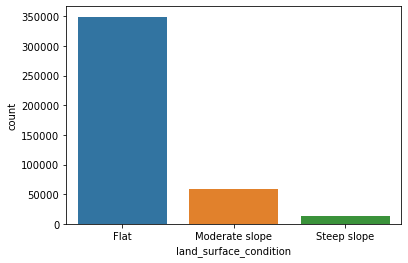

In [9]:
sns.countplot(data['land_surface_condition'])

d:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='count'>

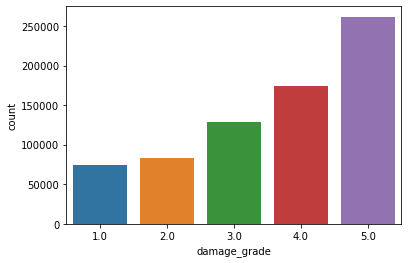

In [15]:
sns.countplot(data['damage_grade'])

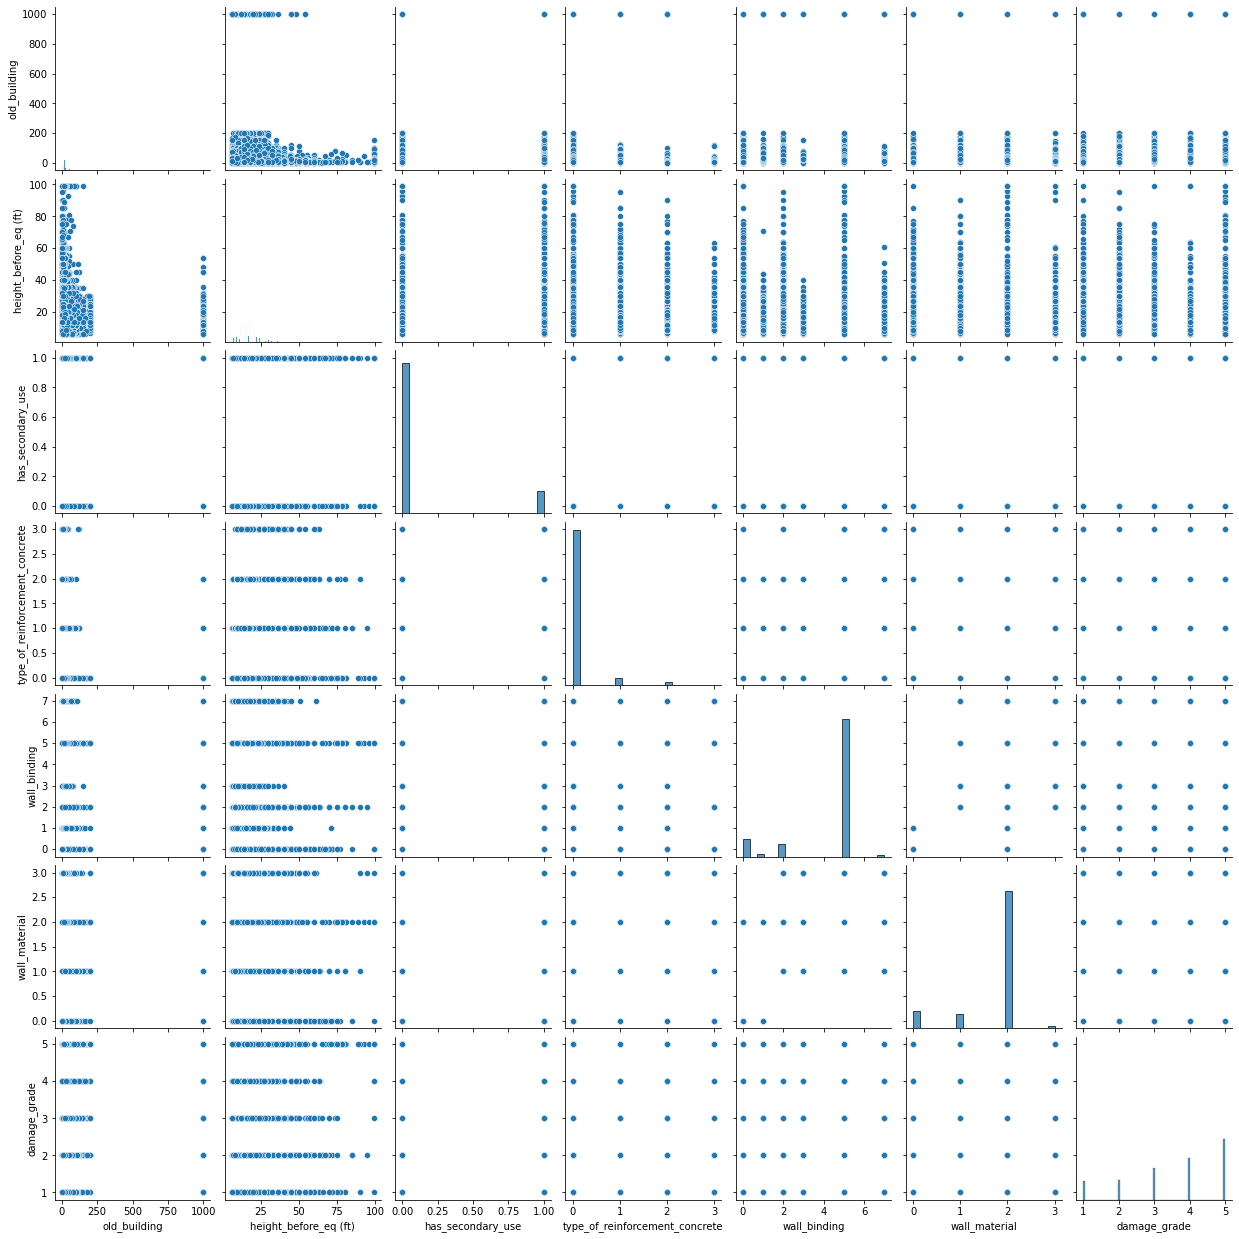

In [20]:
pairs = data.drop_duplicates()
sns.pairplot(pairs)

### Preprocessing

In [21]:
data.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,floor two,1.0,256 ft^2,22.0,Flat,Bamboo or Timber,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
1,Floor 3,3.0,985 ft^2,18.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
2,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
3,two,18.0,185 ft^2,15.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0
4,just 2 floor,22.0,290 ft^2,17.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,Clay,Timber Mud or Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,1.0


In [22]:
data['floors_before_eq (total)'].unique()

array(['floor two', 'Floor 3', 'Two Floor', 'two', ' just 2 floor', nan,
       'There is 2 Floor/Story', 'Floor two', '1st Story', 'Floor 2',
       'fifth', 'Three floor', 'floor one', '2', 'Has 1 floor',
       'one story', 'two story', 'floor second', 'floor third', '3.00',
       '1', ' has 3 Floor', '2 floor', 'three Story', 'Floor 1',
       'floor 1st', 'one', 'Just 1 floor', 'Floor-three', 'Three',
       'four Floor', ' has Four fl', 'Fl four', 'Fl Five', '6', '5', '4',
       'Floor 4', 'floor four', 'Four Story', 'Four', 'Floor Fifth',
       'five Floor', ' Has Five fl', '8', '9', '7', 'Has Five fl'],
      dtype=object)